<a href="https://colab.research.google.com/github/githubpradeep/notebooks/blob/main/nca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class CA(nn.Module):
  def __init__(self, cell_state_dim=16, hidden_dim=128, device ='cpu'):
    super().__init__()
    self.sobel_x = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).repeat(16, 16, 1, 1).to(device)
    self.sobel_y = torch.Tensor([[-1, -2, -1], [0, 0, 0], [1,2,1]]).repeat(16, 16, 1, 1).to(device)

    self.update = nn.Sequential(
        nn.Conv2d(3*cell_state_dim, hidden_dim, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_dim, cell_state_dim, 1),
    )
    self.update = self.update.to(device)
    self.device = device

  def forward(self,x):
    alive_mask = lambda alpha: F.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1

    if x.shape[1] == 4:
      new_x = torch.zeros(x.shape[0], 16, 64, 64).to(self.device)
      new_x[:, :4, :, :] = x
      x = new_x
    alive_mask_pre = alive_mask(alpha=x[:,3:4])
    orig_x = x

    random_mask = torch.randn(64,64) < 0.5
    random_mask = random_mask.to(self.device)

    percept_x = F.conv2d(x, self.sobel_x, padding=1)
    percept_y = F.conv2d(x, self.sobel_y, padding=1)
    x = torch.cat([percept_x, percept_y, x], dim=1)

    dx = self.update(x)

    dx = dx.masked_fill(random_mask, 0)

    x = orig_x + dx

    x = x * alive_mask_pre * alive_mask(alpha=x[:,3:4])
    return x

In [4]:
ca = CA()

In [5]:
x = torch.zeros(1, 4, 64, 64)
ca(x).shape

torch.Size([1, 16, 64, 64])

In [6]:
import requests
import PIL
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms

In [7]:
r = requests.get('https://greydanus.github.io/files/lizard_1f98e.png', stream=True).raw
img = PIL.Image.open(r)  # get image: emoji_u1f98e (🦎)
img.thumbnail((64,64), PIL.Image.ANTIALIAS)

transform = transforms.ToTensor()

# Convert the image to PyTorch tensor
tensor = transform(img)

# print the converted image tensor
print(tensor.shape)

torch.Size([4, 64, 64])


<ipython-input-7-fb0aaf03ae01>:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((64,64), PIL.Image.ANTIALIAS)


In [8]:
target = tensor = transform(img).unsqueeze(0)

In [9]:
target.shape

torch.Size([1, 4, 64, 64])

In [10]:
device = 'cpu'

In [11]:
model = CA(device =device)
model = model.to(device)

In [12]:
x = x.to(device)
y = model(x)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-3)

In [27]:
epochs = 2000
pool_size = 10
import matplotlib.pyplot as plt
from torchvision import utils

KeyboardInterrupt: ignored

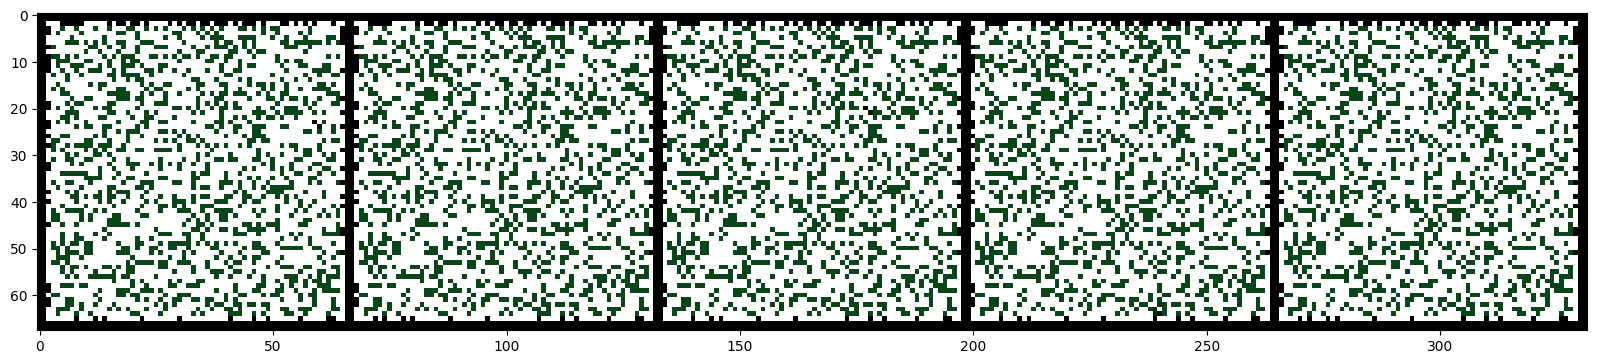

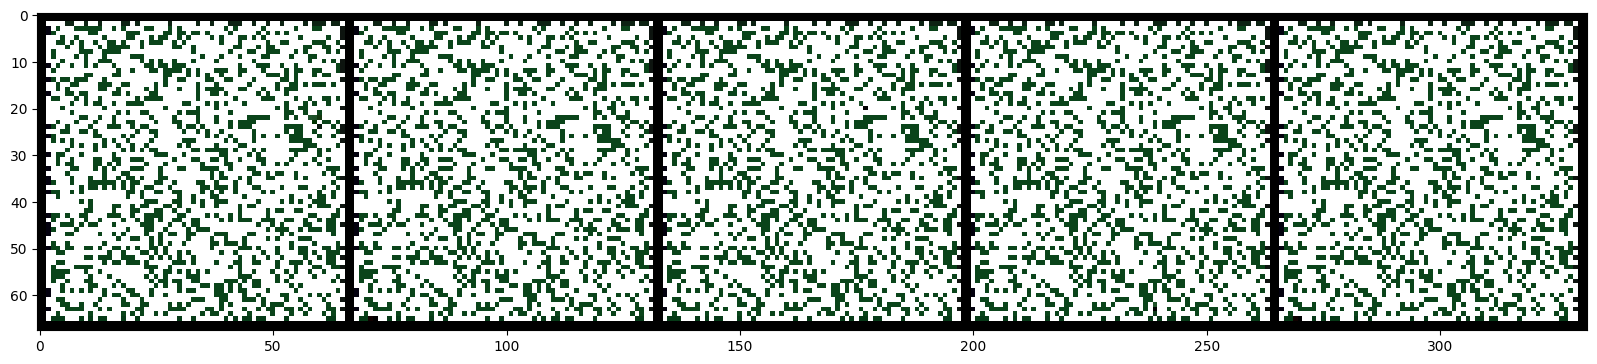

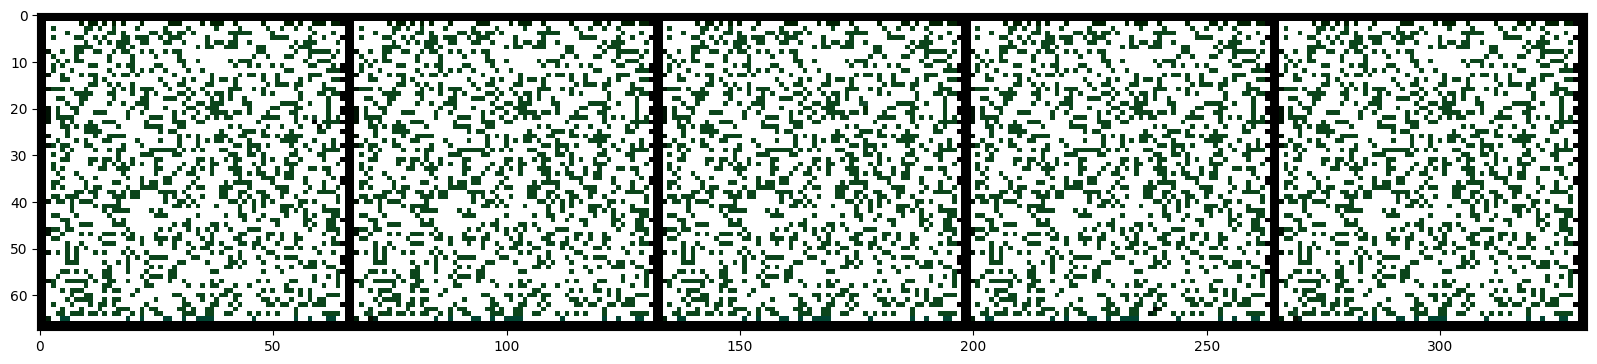

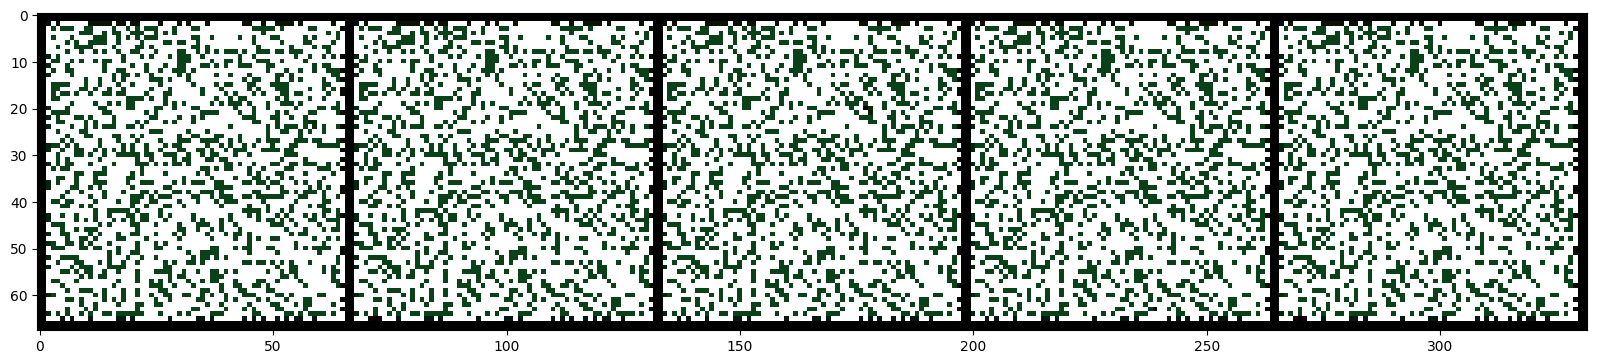

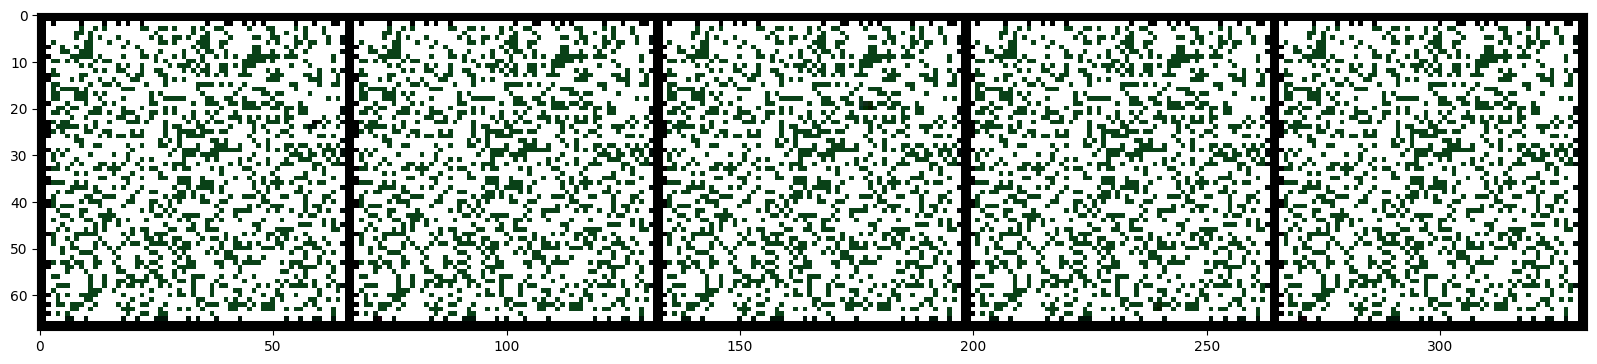

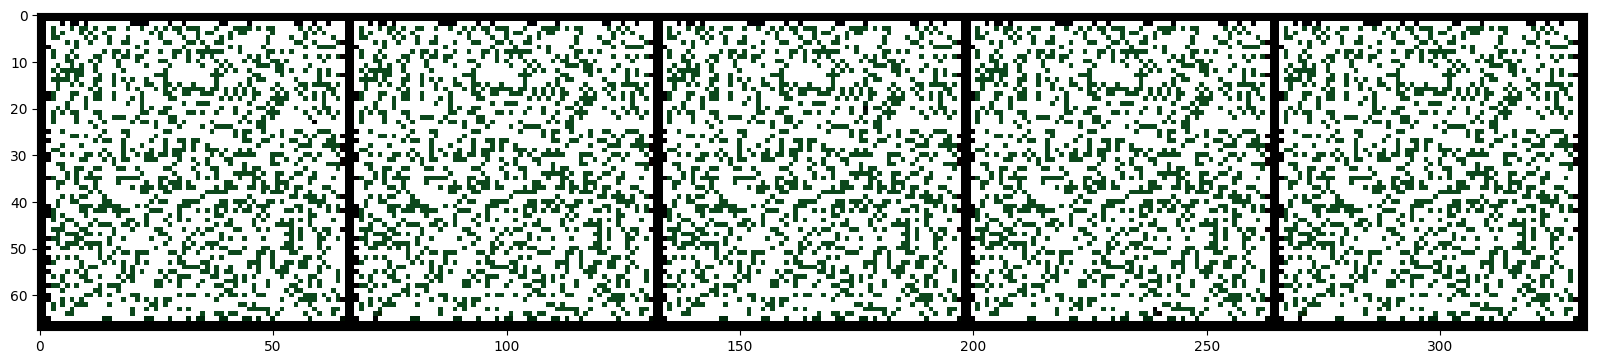

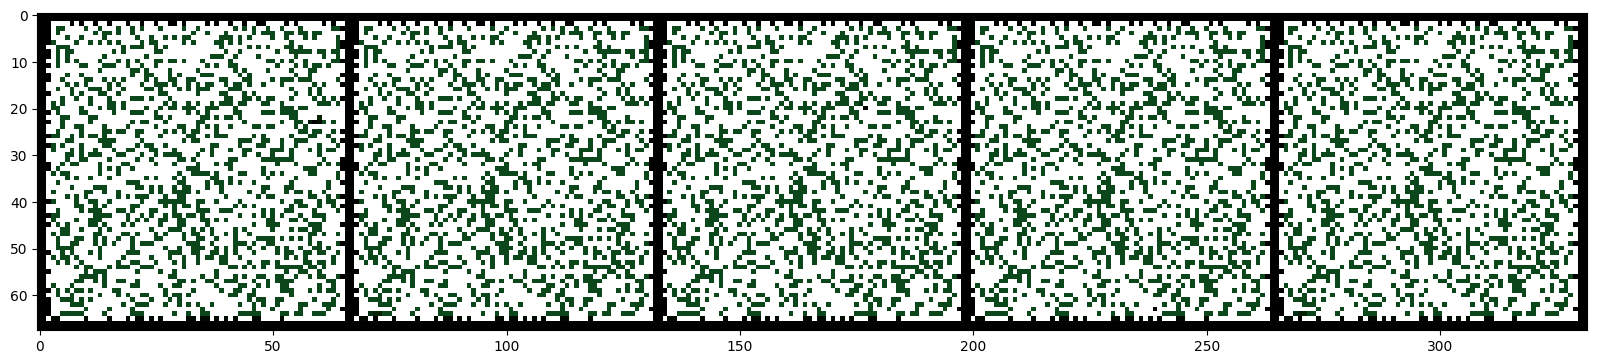

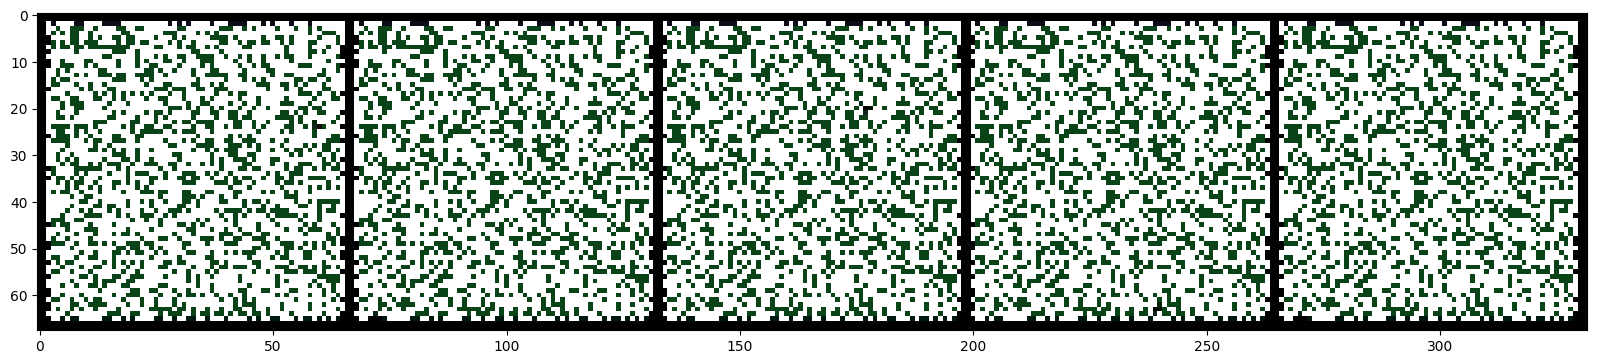

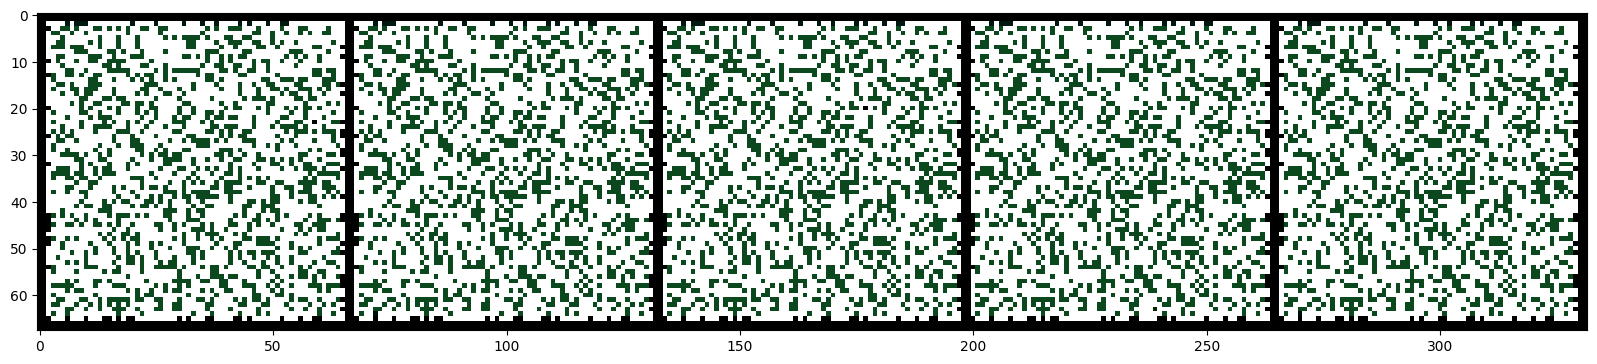

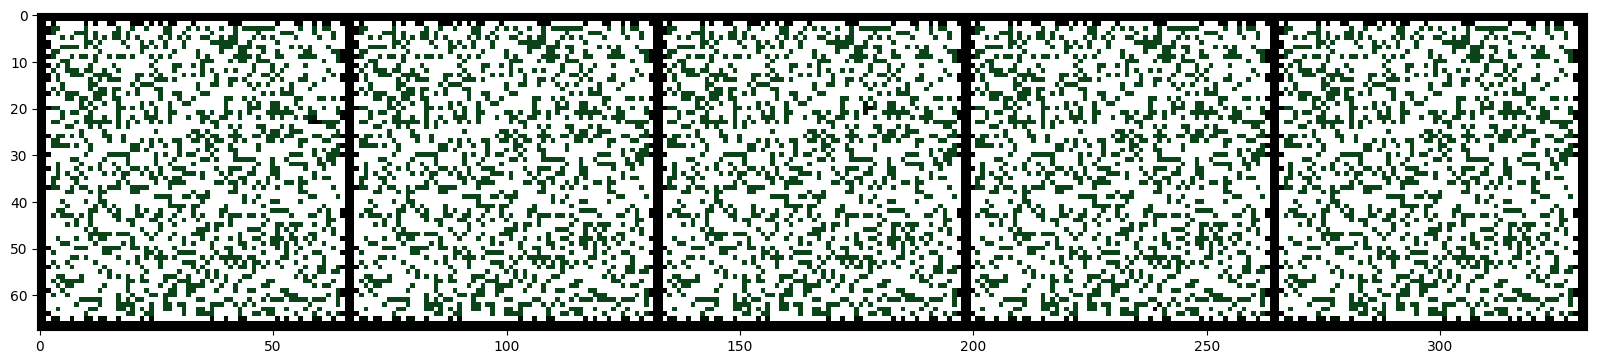

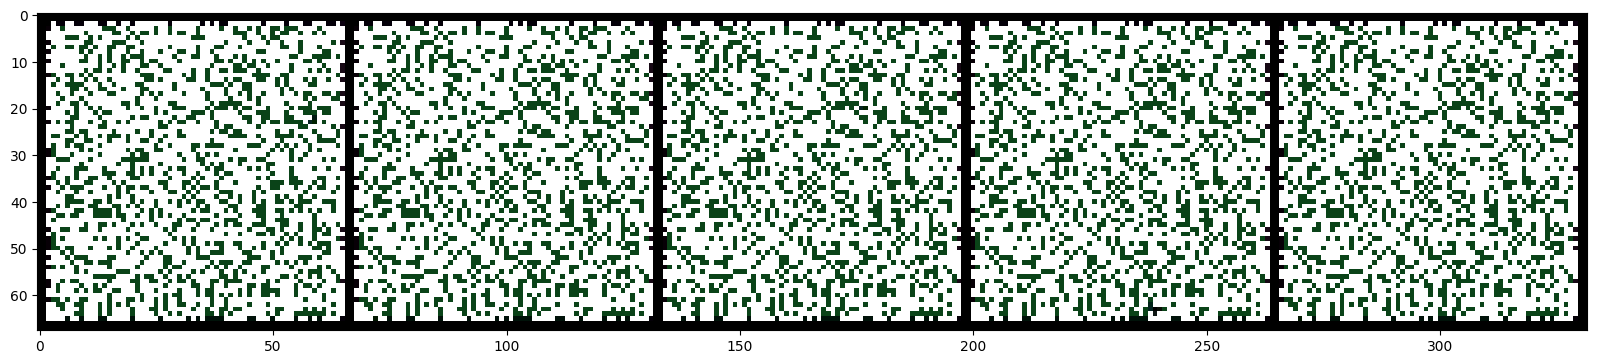

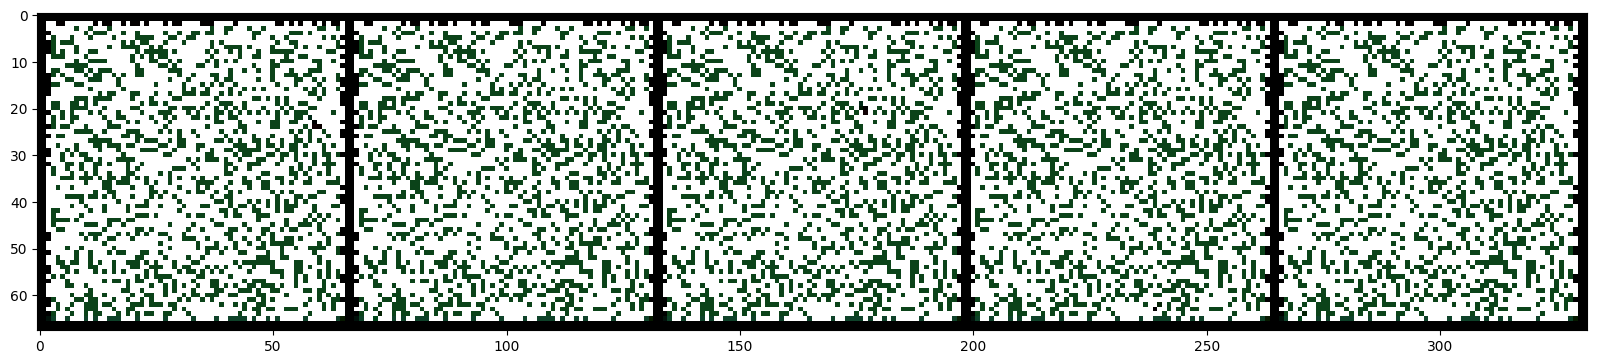

In [28]:
inputs = target.repeat(pool_size,1,1,1)
pool_size = 5

target = target.to(device)
inputs = target.repeat(pool_size,1,1,1)


masked_tensor = torch.ones_like(inputs)

for i in range(inputs.size(0)):
    # Generating random coordinates for the point to keep
    random_x = torch.randint(0, 64, (1,))
    random_y = torch.randint(0, 64, (1,))

    # Keeping the value at the random point
    masked_tensor[i, :, random_x, random_y] = inputs[i, :, random_x, random_y]
inputs = masked_tensor


for epoch in range(epochs):
  new_state = model(inputs)

  mses = (target - new_state[:,:4,:,:]).pow(2)
  batch_mses = mses.view(pool_size,-1).mean(-1)
  loss = batch_mses.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch %100== 0:
    img = new_state[:,:3,:,:].detach().to('cpu')
    grid = utils.make_grid(img, nrow=5)
    plt.figure(figsize = (20,20))

    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [16]:
target.shape

torch.Size([1, 4, 64, 64])

In [24]:

pool_size = 5

target = target.to(device)
inputs = target.repeat(pool_size,1,1,1)


masked_tensor = torch.ones_like(inputs)

for i in range(inputs.size(0)):
    # Generating random coordinates for the point to keep
    random_x = torch.randint(0, 64, (1,))
    random_y = torch.randint(0, 64, (1,))

    # Keeping the value at the random point
    masked_tensor[i, :, random_x, random_y] = inputs[i, :, random_x, random_y]

inputs = masked_tensor
inputs = model(inputs)

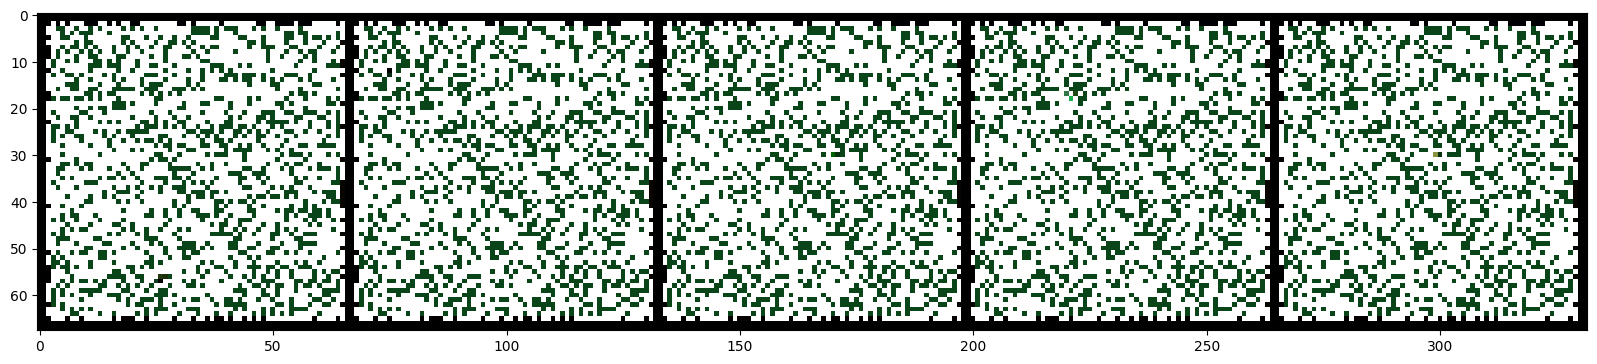

In [26]:

import matplotlib.pyplot as plt
from torchvision import utils
img = inputs[:,:3,:,:].to('cpu')
grid = utils.make_grid(img, nrow=5)
plt.figure(figsize = (20,20))

plt.imshow(grid.numpy().transpose((1, 2, 0)))

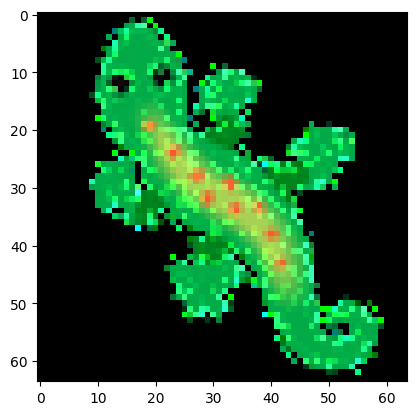

In [313]:
import matplotlib.pyplot as plt
x = target
def to_rgb(img):
    return img[:,:3,:,:]
outs = []
with torch.no_grad():

    x = model(x)
    img = x[:,:3,:,:].to('cpu')
    plt.imshow(  img[0].permute(1, 2, 0)  )




In [239]:
# Creating the tensor
tensor = target.repeat(12,1,1,1)

# Generating random coordinates for the point to keep
random_x = torch.randint(0, 64, (12,))
random_y = torch.randint(0, 64, (12,))

# Masking everything to zero except the random point
masked_tensor = torch.zeros_like(tensor)
masked_tensor[:, :, random_x, random_y] = tensor[:, :, random_x, random_y]

masked_tensor[0].shape


torch.Size([4, 64, 64])

In [231]:
masked_tensor

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          

In [243]:
y.shape

torch.Size([1, 16, 64, 64])

In [245]:
y[:,:4,:,:].shape

torch.Size([1, 4, 64, 64])

In [299]:
torch.randint(0, 64, (pool_size,)).shape

torch.Size([10])